Depois de ter realizado a exploração e limpeza dos dados, é ideal que se faça análises gráficas para entender melhor a relação das variáveis com a variável target (churn) para que a equipe de vendas tenha uma noção do cenário atual e também para que possamos entender de uma forma mais clara e formar possíveis hipóteses do que está acontecendo com os clientes.

O primeiro passo é importar as bibliotecas que serão utilizadas durante o processo de análise, juntamente com o arquivo 'utils', onde estão as funções que estão sendo criadas ao longo do desenvolvimento.

In [1]:
# bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import fisher_exact
from scipy.stats import chisquare, chi2_contingency, mannwhitneyu
from dython import nominal

pd.set_option('display.max_columns', None)

# sns.set_theme(style = 'ticks')
sns.set(style = 'darkgrid')

In [2]:
# carregando os dados
data_root = pd.read_csv('/home/usuario/Pessoal/alura_challenge_ds/dados/data_cleaned.csv', index_col = [0])

# shape
print(f'Formato do arquivo: {data_root.shape[0]} linhas e {data_root.shape[1]} colunas')

# checking dataset
data_root.head()

Formato do arquivo: 7043 linhas e 21 colunas


,id,churn,genero,idoso,parceiro,dependente,permanencia,servico_telefonico,multiplas_linhas,servico_internet,seguranca_online,backup_online,protecao_dispositivo,suporte_tecnico,tv_streaming,filme_streaming,contrato,conta_papel,metodo_pagamento,mensal,total
0,0002-ORFBO,No,Female,No,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30
1,0003-MKNFE,No,Male,No,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40
2,0004-TLHLJ,Yes,Male,No,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,Yes,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,Yes,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40


Será feita uma cópia do dataset original para não ter nenhum problema caso precise de alguma informação original.

In [3]:
# fazendo backup do conjunto de dados original
data = data_root.copy()

Novamente será realizada a análise das colunas para fazer uma melhor separação dos dados, colocando as colunas com os dados de mesmo formato junto, facilitando a etapa de visualização.

In [4]:
# columns analysis
columns_descriptions = []

for column in data.columns:
    column_description = column_analysis(data, column)
    columns_descriptions.append(column_description)

pd.DataFrame(columns_descriptions, columns = ['nome', 'cardinalidade', 'dados_unicos', 'dados_nulos', 'tipo'])

,nome,cardinalidade,dados_unicos,dados_nulos,tipo
0,id,7043,['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9...,0,object
1,churn,2,['No' 'Yes'],0,object
2,genero,2,['Female' 'Male'],0,object
3,idoso,2,['No' 'Yes'],0,object
4,parceiro,2,['Yes' 'No'],0,object
5,dependente,2,['Yes' 'No'],0,object
6,permanencia,73,[ 9 4 13 3 71 63 7 65 54 72 5 56 34 1 45 ...,0,int64
7,servico_telefonico,2,['Yes' 'No'],0,object
8,multiplas_linhas,3,['No' 'Yes' 'No phone service'],0,object
9,servico_internet,3,['DSL' 'Fiber optic' 'No'],0,object


Para organizar melhor as análises, as variáveis derão divididas por seu tipo:
- 1 variável target: 'churn'
- 6 variáveis dicotómicas: 'genero', 'idoso', 'parceiro', 'dependente', 'servico_telefonico' e 'conta_papel';
- 10 variáveis policotómicas: 'multiplas_linhas', 'servico_internet', 'seguranca_online', 'backup_online', 'protecao_dispositivo', 'suporte_tecnico', 'tv_streaming', 'filme_streaming', 'contrato' e 'metodo_pagamento';
- 3 variáveis numéricas: 'permanencia', 'mensal' e 'total'.

In [5]:
# organizando as variáveis por tipo
target_column = ['churn']
categorical_columns = ['genero', 'idoso', 'parceiro', 'dependente', 'servico_telefonico', 'conta_papel', 'multiplas_linhas', 'servico_internet', 'seguranca_online', 'backup_online', 'protecao_dispositivo', 'suporte_tecnico', 'tv_streaming', 'filme_streaming', 'contrato', 'metodo_pagamento']
dichotomic_columns = ['genero', 'idoso', 'parceiro', 'dependente', 'servico_telefonico', 'conta_papel']
polichotomic_columns = ['multiplas_linhas', 'servico_internet', 'seguranca_online', 'backup_online', 'protecao_dispositivo', 'suporte_tecnico', 'tv_streaming', 'filme_streaming', 'contrato', 'metodo_pagamento']
numerical_columns = ['permanencia', 'mensal', 'total']

## Análise Univariada

### Análise de 'target_column'

Verificando a distribuição da variável 'churn' que é a variável target.

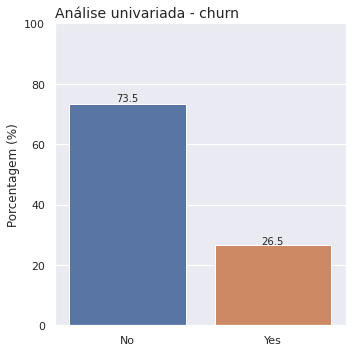

In [6]:
# distribuição da coluna target
plt.figure(figsize = (5, 5))
for position, column in enumerate(target_column):
    plt.subplot(1, 1, position + 1)
    plot_bar(data, column)

plt.tight_layout()

A variável 'churn', que é a variável target, possui uma taxa de 26,5% de clientes que deixaram a base de dados, cerca de 1/4 da base. Isso mostra que ela está desbalanceada, sinalizando um alerta.

### Análise de 'dichotomic_columns'

Segue abaixo a analise das variáveis das colunas que contém valores dicotómicos.

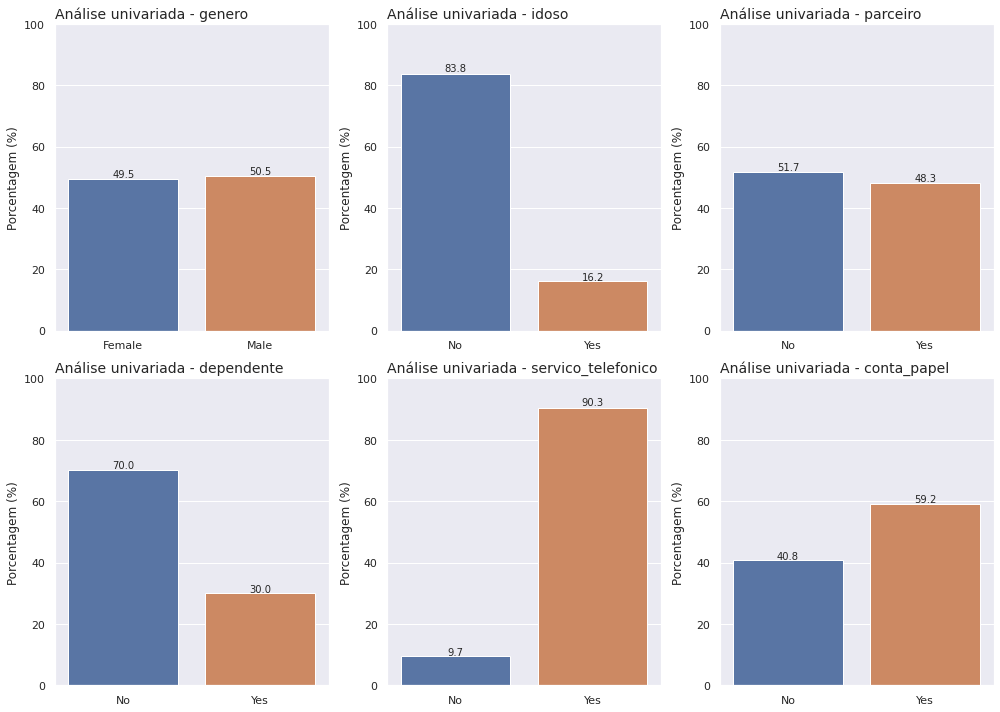

In [7]:
# distriuições das colunas dicotómicas
plt.figure(figsize = (14, 10))
for position, column in enumerate(dichotomic_columns):
    plt.subplot(2, 3, position + 1)
    plot_bar(data, column)

plt.tight_layout()

Inferências das colunas dicotômicas:
- **genero:** a base possui praticamente a mesma proporção de homens e mulheres;
- **idoso:** a maior parte de base é composta por jovens;
- **parceiro:** a base possui praticamente a mesma proporção de pessoas com parceiro e sem parceiro;
- **dependente:** a base possui cerca de 1/3 de possoas sem dependentes;
- **servico_telefonico:** a maior parte da base possui serviço telefonico;
- **conta_papel:** um pouco mais da metade da base recebe conta por papel.

### Análise de 'polichotomic_columns'

Segue abaixo a analise das variáveis das colunas que contém valores policotómicos.

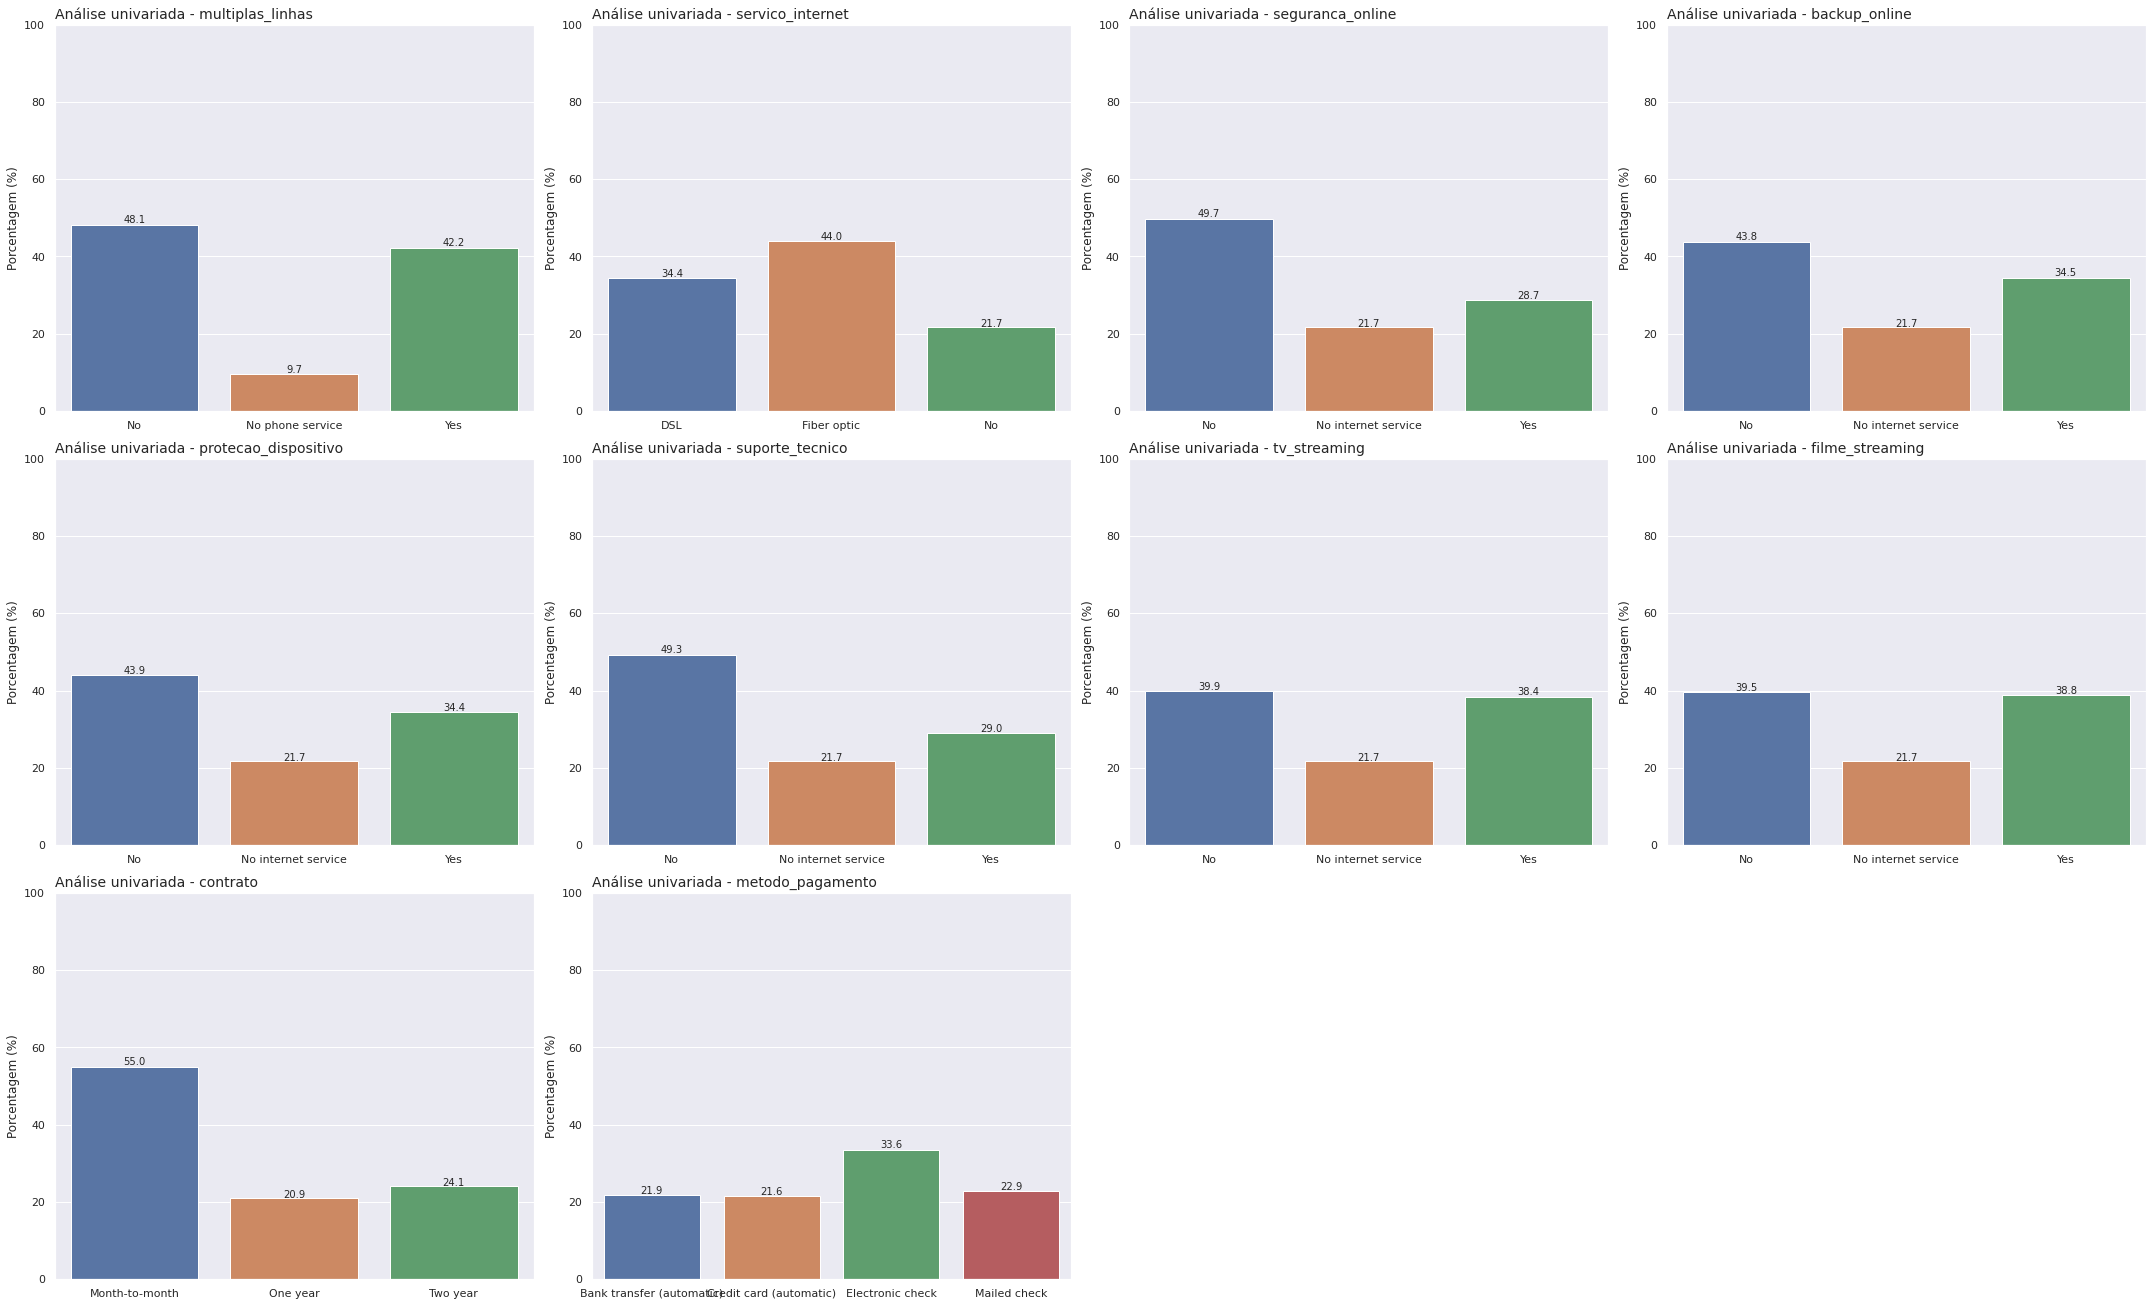

In [8]:
# distriuições das colunas policotomicas
plt.figure(figsize = (30, 24))
for position, column in enumerate(polichotomic_columns):
    plt.subplot(4, 4, position + 1)
    plot_bar(data, column)

plt.tight_layout()
# set the spacing between subplots
# plt.subplots_adjust(left = 0.2, 
#                     right = 1, 
#                     wspace = 0.3, 
#                     hspace = 0.3)
# plt.show()

# distriuições das colunas dicotómicas

Inferências das colunas policotômicas:
- **multiplas_linhas:** dos usuários que possuem serviço telefônico, cerca de metade deles possui multiplas linhas e a outra metade não possui;
- **servico_internet:** dos usuarios que possuem serviço de internet, um pouco mais da metade possui internet de fibra ótica;
- **seguranca_online:** dos usuarios que possuem serviço de internet, a maioria deles não possui nenhum serviço de segurança online;
- **backup_online:** dos usuarios que possuem serviço de internet, um pouco mais da metade não possui serviço de backup online;
- **protecao_dispositivo:** dos usuarios que possuem serviço de internet, um pouco mais da metade não possui serviço de proteção do dispositivo;
- **suporte_tecnico:** dos usuarios que possuem serviço de internet, a maioria deles não possui serviço de suporte técnico;
- **tv_streaming:** dos usuarios que possuem serviço de internet, cerca de metade deles possui stream de tv e a outra metade não possui;
- **filme_streaming:** dos usuarios que possuem serviço de internet, cerca de metade deles possui stream de filme e a outra metade não possui;
- **contrato:** a maioria dos usuários possui um contrato mês a mês, com o outros dois tipos de contrato com quase a mesma proporção;
- **tv_streaming:** a maioria dos usuários opta pelo método de pagamento de cheque eletrônico, com os outros três tipos de métodos de pagamento com quase a mesma proporção.

In [9]:
import pandas as pd
import numpy as np

column = 'dependente'
data_temp = data[['churn', column]].replace({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0})

def TwoSampZ(X1, X2, sigma1, sigma2, N1, N2) :
    from numpy import sqrt, abs, round
    from scipy.stats import norm

    ovr_sigma = sqrt((sigma1 * 2) / (N1 + (sigma2 * 2 / N2)))
    z = (X1 - X2) / ovr_sigma
    pval = 2 * (1 - norm.cdf(abs(z)))
    return z, pval

d1 = data_temp[(data_temp[column] == 1)]['churn'] 
d2 = data_temp[(data_temp[column] == 0)]['churn']

m1, m2 = d1.mean(), d2.mean()
sd1, sd2 = d1.std(), d2.std ()
n1, n2 = d1.shape[0], d2.shape[0]

z, p = TwoSampZ(m1, m2, sd1, sd2, n1, n2)

z_score = np.round(z, 8) 
p_val = np.round(p, 6)

if (p_val < 0.05):
    hypothesis_status = 'Reject Null Hypothesis: Significant'
else:
    hypothesis_status = 'Do not reject Null Hypothesis: Not Significant'

print(p_val)
print(hypothesis_status)

0.0
Reject Null Hypothesis: Significant


In [10]:
data_temp

,churn,dependente
0,0,1
1,0,0
2,1,0
3,1,0
4,1,0
...,...,...
7262,0,0
7263,1,0
7264,0,0
7265,0,1


### Análise de 'numerical_columns'

Segue abaixo a analise das variáveis das colunas que contém valores numéricos.

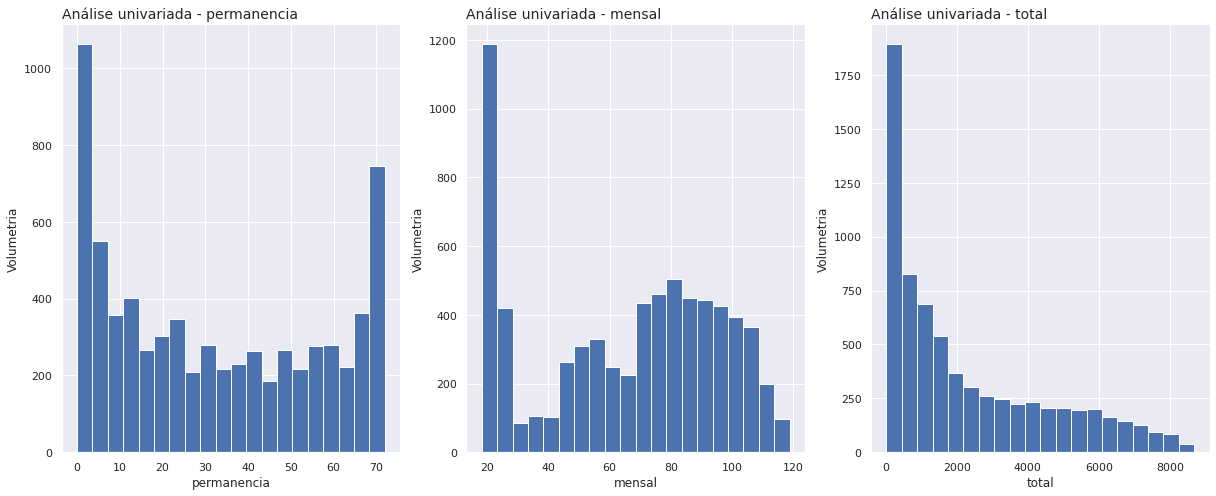

In [11]:
# distriuições das colunas numericas
plt.figure(figsize = (17, 7))
for position, column in enumerate(numerical_columns):
    plt.subplot(1, 3, position + 1)
    plot_hist(data, column)

plt.tight_layout()
plt.show()

Para melhorar e ajudar na análise acima, serão geradas algumas medidas estatísticas das colunas numéricas.

In [12]:
# medidas estatísticas das colunas númericas
data[numerical_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
permanencia,7043.0,32.371149,24.559481,0.00,9.00,29.00,55.00,72.00
mensal,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
total,7043.0,2279.798992,2266.730170,18.80,398.55,1394.55,3786.60,8684.80


## Análise Bivariada

### Variáveis Dicotómicas

#### Teste Estatístico (dicotómicas)

- H0: Não há diferença entre os grupos
- H1: Há diferença entre os grupos

* Se o p_value for maior que 5%, não rejeitar a hipótese nula
* Se o p_value for menor que 5%, rejeitar a hipótese nula

In [13]:
# aplicando o teste estatístico de comparação entre a coluna que se quer avaliar e a coluna 'churn'
# Chi-square of Goodness of fit test
p_values_churn_yes = []
p_values_churn_no = []
results_churn_yes = []
results_churn_no = []
columns = dichotomic_columns
significance = 0.05

for column in columns:
    odds, p_value = chisquare(pd.crosstab(data[column], data.churn))

    p_values_churn_yes.append(p_value[1].round(4))
    p_values_churn_no.append(p_value[0].round(4))

    if p_value[1] > significance:
        result_yes = 'Não rejeita H0, não há diferença entre os grupos'
    else:
        result_yes = 'Rejeita H0, há diferença entre os grupos'

    if p_value[0] > significance:
        result_no = 'Não rejeita H0, não há diferença entre os grupos'
    else:
        result_no = 'Rejeita H0, há diferença entre os grupos'

    results_churn_yes.append(result_yes)
    results_churn_no.append(result_no)

pd.DataFrame({'p_value (churn = Yes)': p_values_churn_yes,
              'result (churn = Yes)': results_churn_yes,
              'p_value (churn = No)': p_values_churn_no,
              'result (churn = No)': results_churn_no}, 
              index = columns)

,p_value (churn = Yes),result (churn = Yes),p_value (churn = No),result (churn = No)
genero,0.8351,"Não rejeita H0, não há diferença entre os grupos",0.2907,"Não rejeita H0, não há diferença entre os grupos"
idoso,0.0000,"Rejeita H0, há diferença entre os grupos",0.0000,"Rejeita H0, há diferença entre os grupos"
parceiro,0.0000,"Rejeita H0, há diferença entre os grupos",0.0000,"Rejeita H0, há diferença entre os grupos"
dependente,0.0000,"Rejeita H0, há diferença entre os grupos",0.0000,"Rejeita H0, há diferença entre os grupos"
servico_telefonico,0.0000,"Rejeita H0, há diferença entre os grupos",0.0000,"Rejeita H0, há diferença entre os grupos"
conta_papel,0.0000,"Rejeita H0, há diferença entre os grupos",0.0000,"Rejeita H0, há diferença entre os grupos"


Será aplicado um teste estatístico para verificar se há diferença entre os grupos de comparação ou não.

##### Churn vs Gênero

Embora o teste estatístico já tenha mostrado que não há diferença entre ser do sexo masculino ou feminino para ser 'churn', tanto 'Yes' quanto 'No', irei fazer essa análise gráfica.

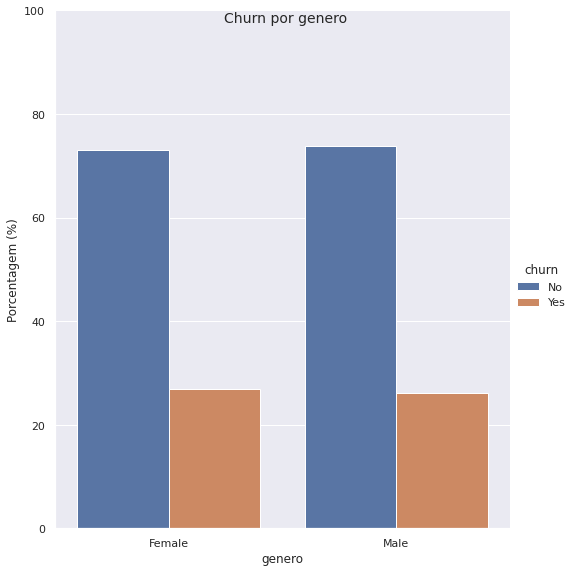

In [14]:
# comparação da proporção de 'churn' por 'genero'
plot_catplot(data, 'genero')

A partir do gráfico acima pode-se notar que a variável 'genero' não tem impacto na variável 'churn', uma vez que elas apresentam basicamente a mesma proporção de 'churn' entre os sexos feminino e masculino.

##### Churn vs Idoso

Pelo teste estatístico tem-se que há diferença estatística na proporção de churn por ser idoso ou não.

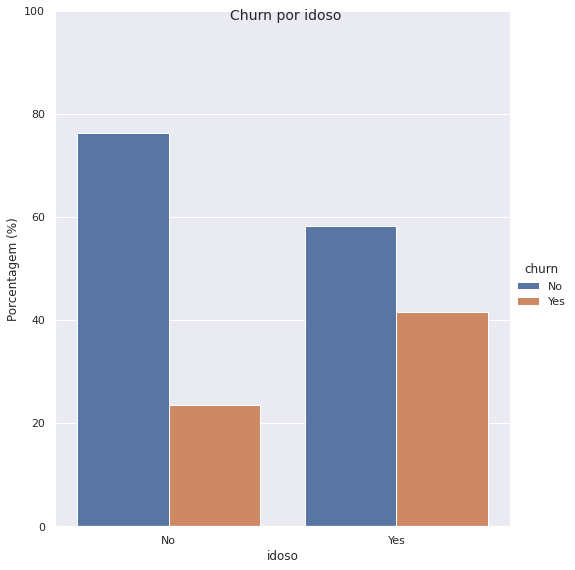

In [15]:
# comparação da proporção de 'churn' por 'idoso'
plot_catplot(data, 'idoso')

É possível observar que cerca de 40% das pessoas que são idosas são churn contra um pouco mais de 20% das pessoas que são jovens. Então, o fato da pessoa ser idosa indica que ela possui maiores chances de ser churn.

##### Churn vs Parceiro

Pelo teste estatístico tem-se que há diferença estatística na proporção de churn por ter parceiro ou não.

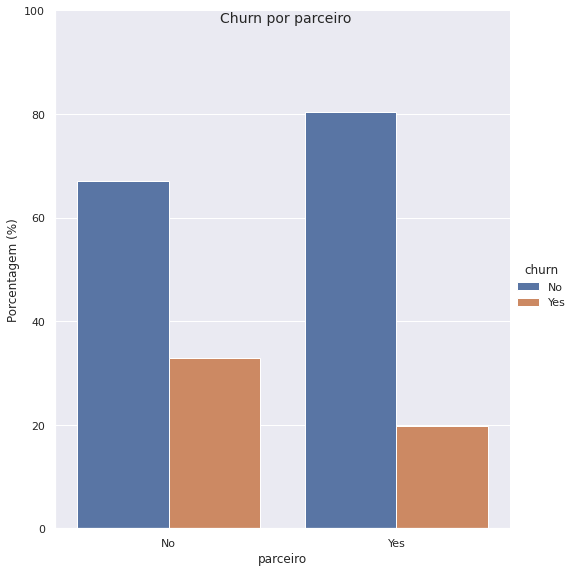

In [16]:
# comparação da proporção de 'churn' por 'parceiro'
plot_catplot(data, 'parceiro')

##### Churn vs Dependente

Pelo teste estatístico tem-se que há diferença estatística na proporção de churn por ter dependente ou não.

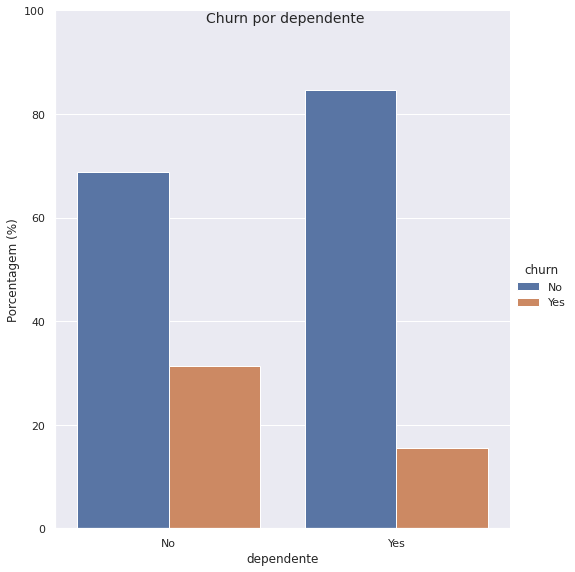

In [17]:
# comparação da proporção de 'churn' por 'dependente'
plot_catplot(data, 'dependente')

##### Churn vs Serviço Telefônico

Pelo teste estatístico tem-se que há diferença estatística na proporção de churn por ter servico_telefonico ou não.

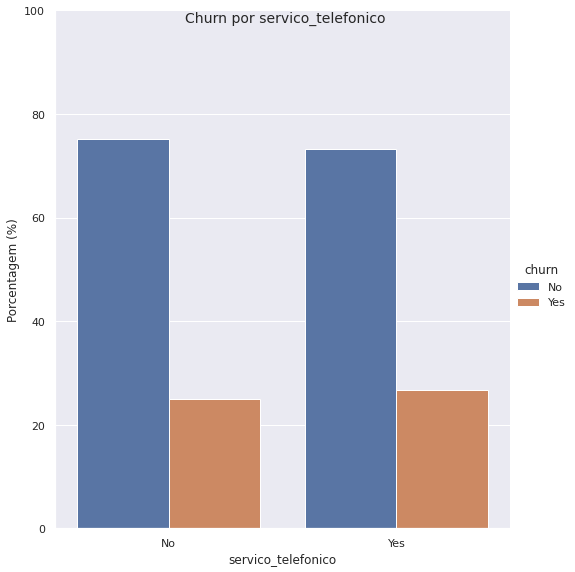

In [18]:
# comparação da proporção de 'churn' por 'servico_telefonico'
plot_catplot(data, 'servico_telefonico')

##### Churn vs Conta papel

#### Variáveis Policotómicas

##### Teste Estatístico (policotómicas)

- H0: Os grupos são independentes
- H1: Os grupos são dependentes

* Se o p_value for maior que 5%, não rejeitar a hipótese nula
* Se o p_value for menor que 5%, rejeitar a hipótese nula

In [19]:
# aplicando o teste estatístico de comparação entre a coluna que se quer avaliar e a coluna 'churn' 
# Chi-square test for independence
p_values = []
results = []
significance = 0.05
columns = polichotomic_columns

for column in columns:
    chi2_statistic, p_value, dof = chi2_contingency(pd.crosstab(data[column], data.churn))[0:3]

    p_values.append(p_value.round(4))

    if p_value > significance:
        result = 'Independentes (Não rejeitar H0)'
    else:
        result = 'Dependentes (Rejeitar H0)' #there is no effect of group in choosing the equipment to use

    results.append(result)

pd.DataFrame({'p_value': p_values,
              'result': results},
              index = columns)

,p_value,result
multiplas_linhas,0.0035,Dependentes (Rejeitar H0)
servico_internet,0.0000,Dependentes (Rejeitar H0)
seguranca_online,0.0000,Dependentes (Rejeitar H0)
backup_online,0.0000,Dependentes (Rejeitar H0)
protecao_dispositivo,0.0000,Dependentes (Rejeitar H0)
suporte_tecnico,0.0000,Dependentes (Rejeitar H0)
tv_streaming,0.0000,Dependentes (Rejeitar H0)
filme_streaming,0.0000,Dependentes (Rejeitar H0)
contrato,0.0000,Dependentes (Rejeitar H0)
metodo_pagamento,0.0000,Dependentes (Rejeitar H0)


##### Churn vs Multiplas Linhas

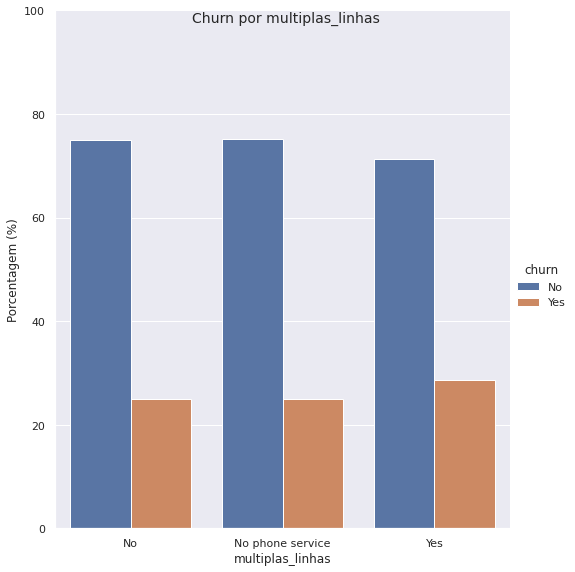

In [20]:
# comparação da proporção de 'churn' por 'multiplas_linhas'
plot_catplot(data, 'multiplas_linhas')

##### Churn vs Serviço Internet

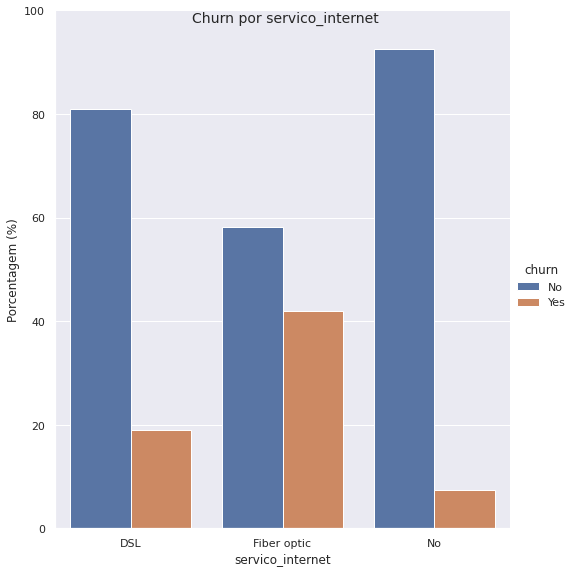

In [21]:
# comparação da proporção de 'churn' por 'servico_internet'
plot_catplot(data, 'servico_internet')

##### Churn vs Serviços Online

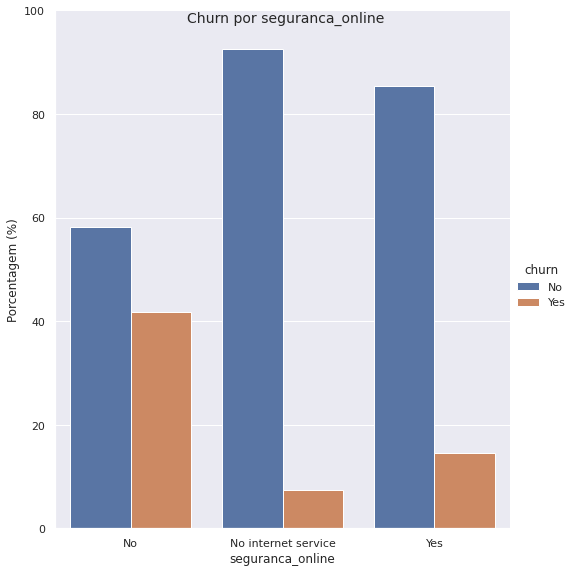

In [22]:
# comparação da proporção de 'churn' por 'seguranca_online'
plot_catplot(data, 'seguranca_online')

##### Churn vs Backup Online

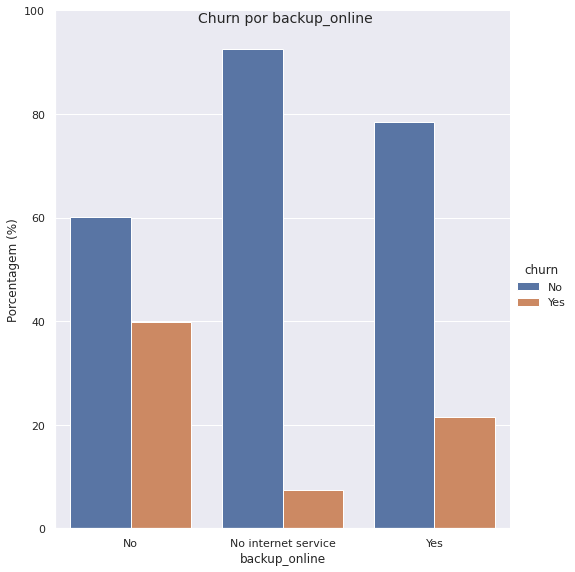

In [23]:
# comparação da proporção de 'churn' por 'backup_online'
plot_catplot(data, 'backup_online')

##### Churn vs Proteção do Dispositivo

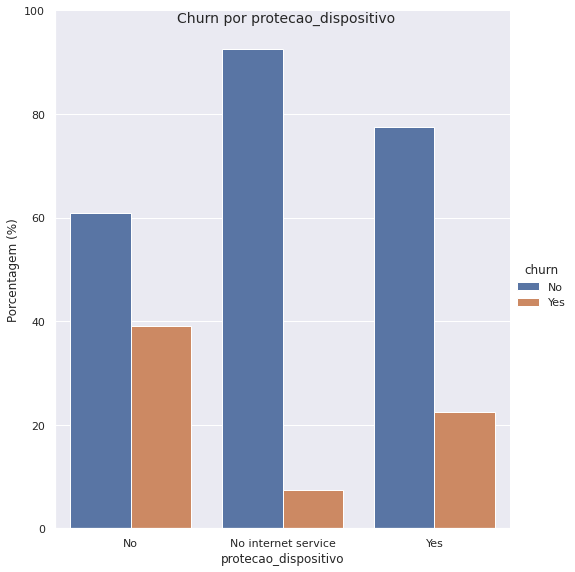

In [24]:
# comparação da proporção de 'churn' por 'protecao_dispositivo'
plot_catplot(data, 'protecao_dispositivo')

##### Churn vs Suporte Técnico

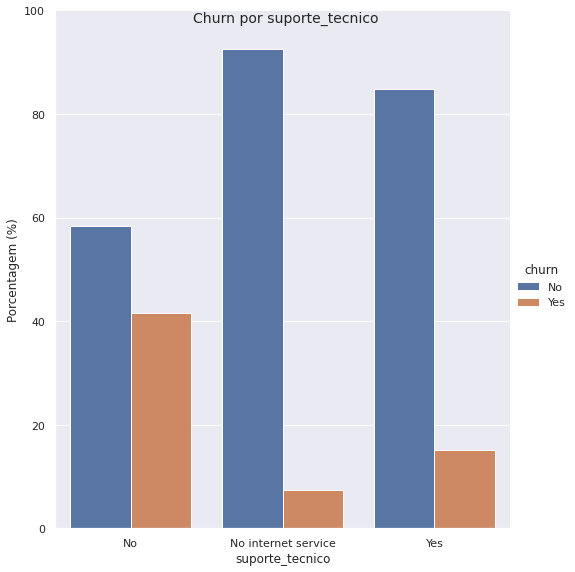

In [25]:
# comparação da proporção de 'churn' por 'suporte_tecnico'
plot_catplot(data, 'suporte_tecnico')

##### Churn vs TV Streaming

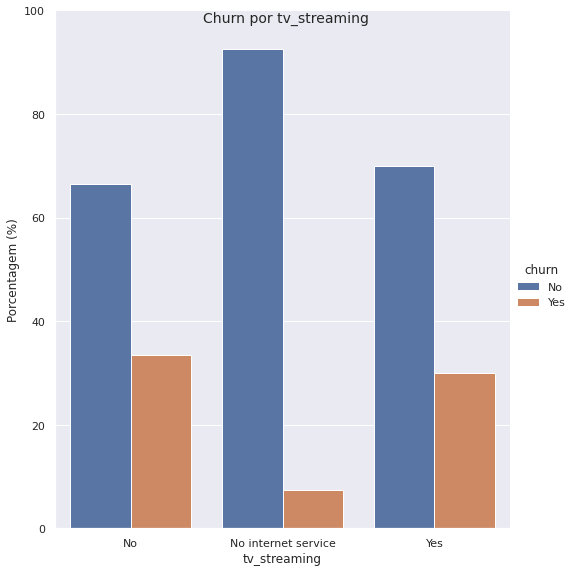

In [26]:
# comparação da proporção de 'churn' por 'tv_streaming'
plot_catplot(data, 'tv_streaming')

##### Churn vs Filme Streaming

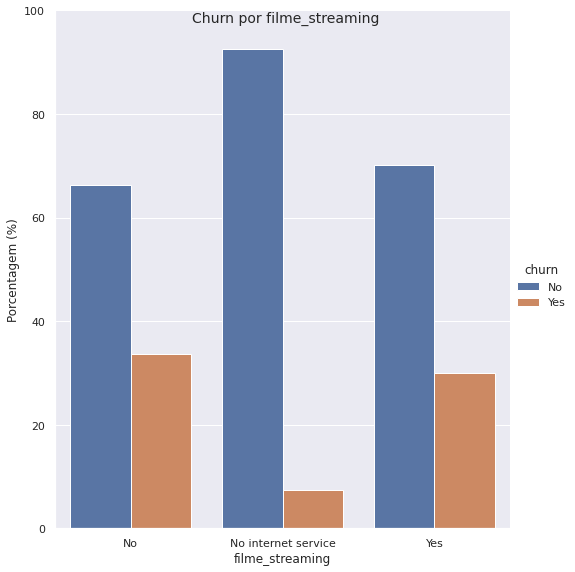

In [27]:
# comparação da proporção de 'churn' por 'filme_streaming'
plot_catplot(data, 'filme_streaming')

##### Churn vs Contrato

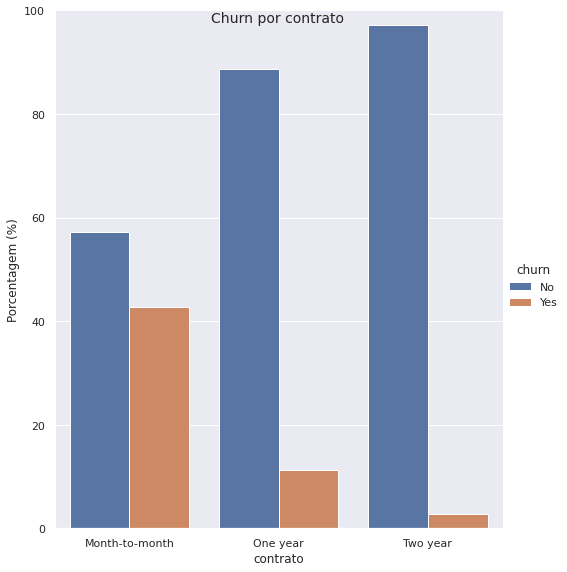

In [28]:
# comparação da proporção de 'churn' por 'contrato'
plot_catplot(data, 'contrato')

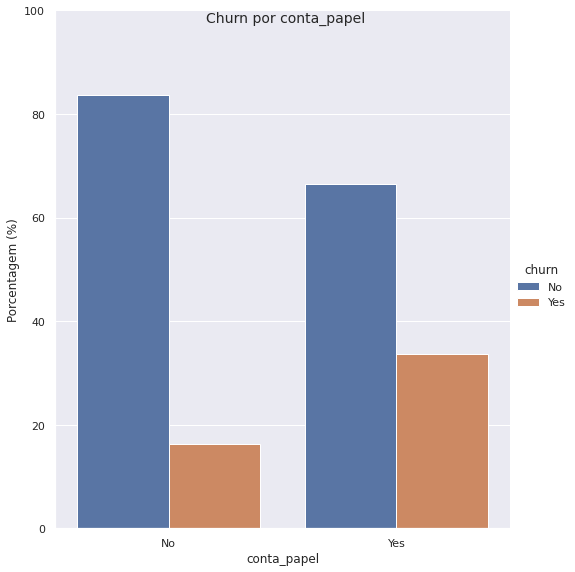

In [29]:
# comparação da proporção de 'churn' por 'conta_papel'
plot_catplot(data, 'conta_papel')

##### Churn vs Método pagamento

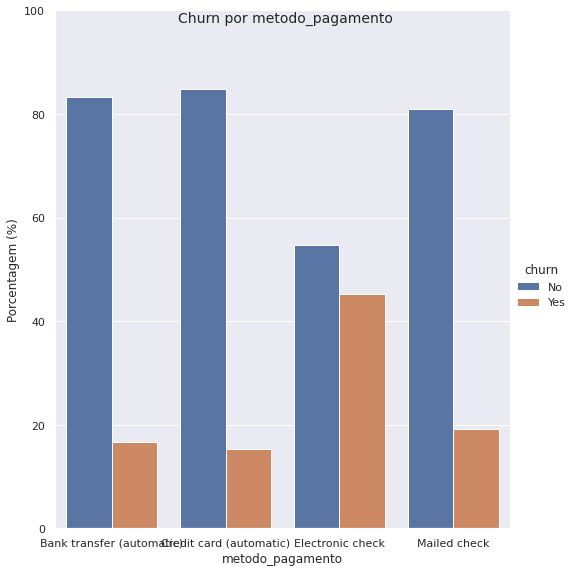

In [30]:
# comparação da proporção de 'churn' por 'metodo_pagamento'
plot_catplot(data, 'metodo_pagamento')

#### Variáveis Numéricas

##### Teste Estatístico (numéricas)

- H0: As médias são iguais
- H1: Há diferença entre as médias

* Se o p_value for maior que 5%, não rejeitar a hipótese nula
* Se o p_value for menor que 5%, rejeitar a hipótese nula

In [31]:
# 
columns = numerical_columns
significance = 0.05
p_values = []
results = []

for column in columns:
    statistic, p_value = mannwhitneyu(data[data.churn == 'Yes'][column], data[data.churn == 'No'][column])
    
    p_values.append(p_value.round(4))

    if p_value <= significance:
        result = 'Rejeitar H0'
    else:
        result = 'Não rejeitar H0'

    results.append(result)


pd.DataFrame({
    'p_value': p_values,
    'result': results
}, index = columns)

,p_value,result
permanencia,0.0,Rejeitar H0
mensal,0.0,Rejeitar H0
total,0.0,Rejeitar H0


##### Churn vs Permanencia

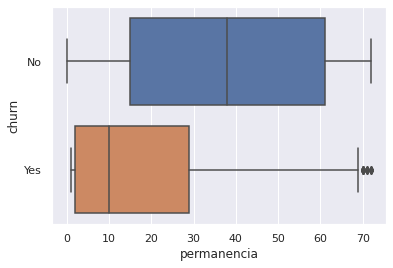

In [32]:
sns.boxplot(data = data[numerical_columns + target_column], x = 'permanencia', y = 'churn')

plt.show()

##### Churn vs Mensal

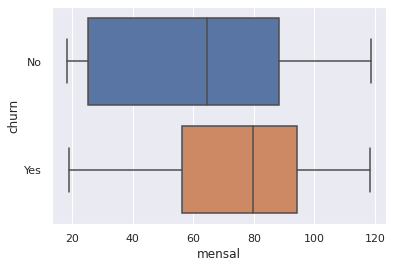

In [33]:
sns.boxplot(data = data[numerical_columns + target_column], x = 'mensal', y = 'churn')

plt.show()

##### Churn vs Total

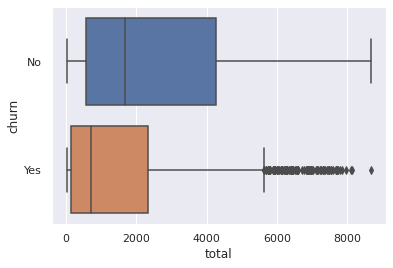

In [34]:
sns.boxplot(data = data[numerical_columns + target_column], x = 'total', y = 'churn')

plt.show()

### Correlação entre as variáveis

#### Feature Selection

##### Correlação

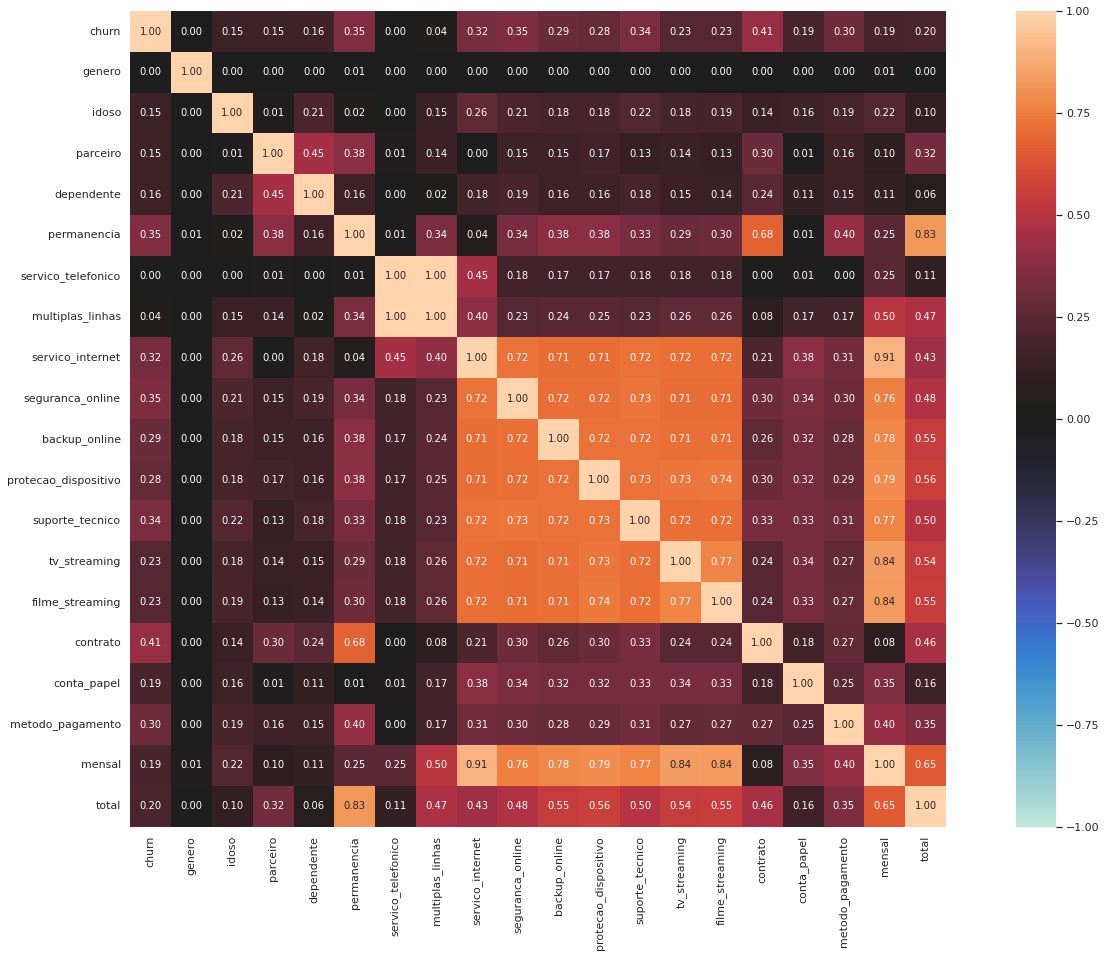

In [35]:
a = nominal.associations(data.iloc[:, 1:], figsize = (25, 15));

In [36]:
b = pd.DataFrame(a['corr'])
columns_correlation = b[b['churn'] > 0.3].index
columns_correlation

Index(['churn', 'permanencia', 'servico_internet', 'seguranca_online',
       'suporte_tecnico', 'contrato', 'metodo_pagamento'],
      dtype='object')

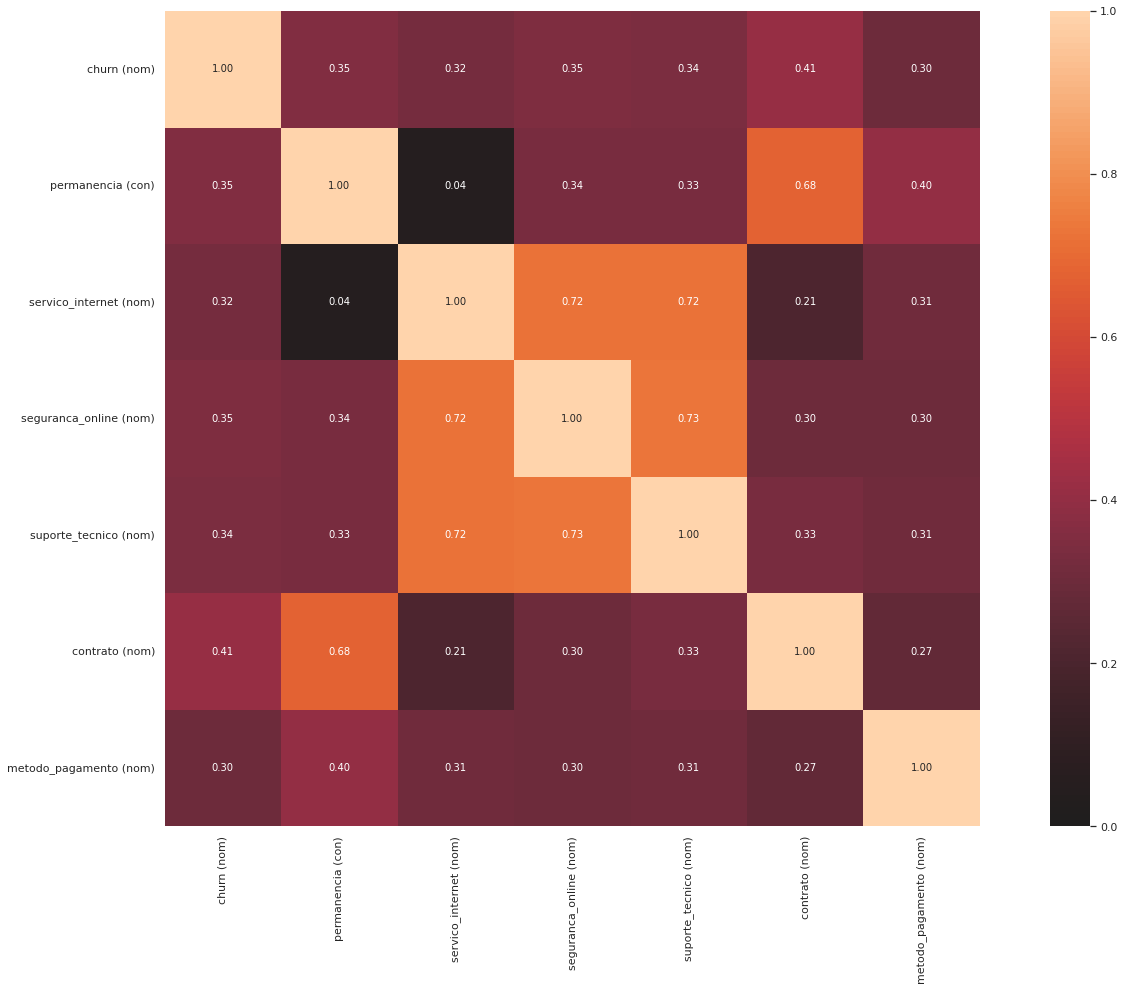

In [37]:
nominal.associations(data[columns_correlation], figsize = (25, 15), mark_columns = True);

##### Chi-square Test

In [38]:
x = data[data == data.astype(object)].drop(['id', 'churn'], axis = 1)
y = data[data == data.astype(object)].churn

In [39]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

In [40]:
fs = SelectKBest(score_func = chi2, k = 'all')
fs.fit(x, y)
# X_train_fs = fs.transform(x)

ValueError: could not convert string to float: 'Female'

In [ ]:
model = SelectKBest(mutual_info_classif, k = 2)

In [ ]:
x.iloc[:, 1:4].replace({'Yes': 1, 'No': 0})

,idoso,parceiro,dependente
0,0,1,1
1,0,0,0
2,0,0,0
3,1,1,0
4,1,1,0
...,...,...,...
7262,0,0,0
7263,0,1,0
7264,0,0,0
7265,0,1,1


In [ ]:
z = x.iloc[:, 1:4].replace({'Yes': 1, 'No': 0})

In [ ]:
new = model.fit(z, y)

In [ ]:
new.transform(z)

array([[0, 1],
       [0, 0],
       [0, 0],
       ...,
       [0, 0],
       [0, 1],
       [0, 1]])

In [ ]:
new.get_support(indices = True)

array([0, 2])

In [ ]:
x.replace({'Yes': 1, 'No': 0, 'Female': 0, 'Male': 1})

##### FeatureWiz

,servico_internet,contrato,suporte_tecnico,seguranca_online,servico_telefonico,filme_streaming,permanencia,multiplas_linhas,backup_online,idoso,conta_papel,parceiro,tv_streaming,metodo_pagamento,protecao_dispositivo,churn
0,1,2,1,0,0,0,9,0,1,0,0,1,1,1,0,0
1,1,0,0,0,0,1,9,1,0,0,1,0,0,1,0,0
2,0,0,0,0,0,0,4,0,0,0,0,0,0,0,1,1
3,0,0,0,0,0,1,13,0,1,1,0,1,1,0,1,1
4,0,0,1,0,0,0,3,0,0,1,0,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7262,1,2,1,1,0,0,13,0,0,0,1,0,0,1,0,0
7263,0,0,0,0,0,1,22,1,0,0,0,1,0,0,0,1
7264,1,0,0,0,0,0,2,0,1,0,0,0,0,1,0,0
7265,1,1,1,1,0,1,67,0,0,0,1,1,0,1,1,0


# TESTES

In [ ]:
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

NameError: name 'StandardScaler' is not defined

In [ ]:
model = LogisticRegression()

In [ ]:
model.fit(x_train, y_train)

In [ ]:
model.predict(x_test)

In [ ]:
data.churn.value_counts(normalize = True)

In [ ]:
data.head()

In [ ]:
pd.concat([data.churn.value_counts().to_frame(), data.churn.value_counts(normalize = True).to_frame()], axis = 1).set_axis(['churn', 'churn_rate'], axis = 1)

In [ ]:
data.loc[:, ['churn', 'permanencia', 'mensal']].groupby('churn').agg({
    'permanencia': 'count',
    'mensal': lambda x: x.mean()
})

In [42]:
pd.pivot_table(columns = 'churn', index = 'servico_internet', values = 'mensal', data = data).round(2)

churn,No,Yes
servico_internet,,
DSL,60.21,49.08
Fiber optic,93.93,88.13
No,21.14,20.37


In [41]:
pd.crosstab(data.churn, data.idoso, normalize = True)

idoso,No,Yes
churn,,
No,0.640068,0.094562
Yes,0.197785,0.067585


In [ ]:
pd.pivot_table(index = data.churn, data = data)

In [ ]:
data.groupby('churn').mean()

In [ ]:
plt.figure(figsize = (26, 17))
for position, column in enumerate(target_column):
    plt.subplot(3, 5, position + 1)
    plot_bar(data, column)

plt.tight_layout()

/home/usuario/Pessoal/alura_challenge_ds/alura_challenge_ds_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='permanencia', ylabel='mensal'>

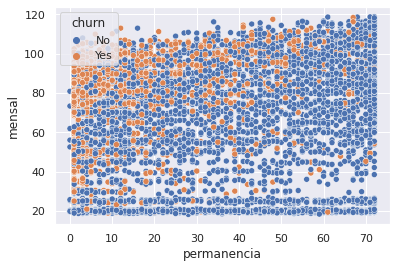

In [53]:
sns.scatterplot(data.permanencia, data.mensal, hue = data.churn)